In [1]:
import sys, os
sys.path.append("../../")

import pandas as pd

from utils.contract_utils import init_contract
from utils.network_utils import configure_network

from brownie.network import connect, accounts, chain
from brownie_tokens import MintableForkToken
from brownie.exceptions import VirtualMachineError

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)
connect('mainnet-fork')


Launching 'ganache-cli --port 8545 --gasLimit 12000000 --accounts 10 --hardfork istanbul --mnemonic brownie --fork https://eth-mainnet.alchemyapi.io/v2/AxU0de70ONfvbD-3_pQX0wUlaBK6g3G4 --chainId 1'...


In [4]:
pool_contract_addr = "0x5a6A4D54456819380173272A5E8E9B9904BdF41B"  # cvxcrv pool addr
pool_contract = init_contract(contract_addr=pool_contract_addr)
pool_contract.name()

'Curve.fi Factory USD Metapool: Magic Internet Money 3Pool'

In [5]:
pool_coin_addrs = []
for i in range(10):
    try:
        pool_coin_addrs.append(pool_contract.coins(i))
    except:
        break
pool_coin_addrs

['0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3',
 '0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490']

In [6]:
pool_balances = pool_contract.get_balances()
print(pool_balances[0] * 1e-18, pool_balances[1] * 1e-18)

1308012384.9254172 487316322.3098215


In [7]:
total_coins = (pool_balances[1]+pool_balances[0])
print(f"coin 0 percentage: {pool_balances[0]/total_coins * 100}")
print(f"coin 1 percentage: {pool_balances[1]/total_coins * 100}")

coin 0 percentage: 72.85642900122305
coin 1 percentage: 27.143570998776955


In [8]:
token_1 = init_contract(contract_addr=pool_coin_addrs[1])

In [9]:
amount = 10 * 1E6 * 1e18  # 50 million tokens swapped in each swap
token_0 = MintableForkToken(pool_coin_addrs[0])  # mim
min_amount_received = int(0.5 * amount)

mint_token_0_amount = 500 * 1E6
# mint a lot of token_0: the one which we want to swap into the pool to cause a depeg
token_0._mint_for_testing(accounts[0], mint_token_0_amount * 1E18)

Transaction sent: 0xcb24cbac6e745e3937fdeb59bd5c810c0a1600f133f6d779a655e4245660ba9d
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 1
  MagicInternetMoneyV1.transfer confirmed   Block: 14089377   Gas used: 50951 (0.42%)



In [10]:
# approve large amount of money
token_0.approve(pool_contract_addr, amount * 1e18, {"from": accounts[0]})

Transaction sent: 0x0bf0bd75f22ef520af66a41bbe50a33143c8997c809295fae2a2c01cf63c4ee2
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 2
  MagicInternetMoneyV1.approve confirmed   Block: 14089378   Gas used: 44195 (0.37%)



<Transaction '0x0bf0bd75f22ef520af66a41bbe50a33143c8997c809295fae2a2c01cf63c4ee2'>

In [11]:
swap_data = []
chain.snapshot()

In [18]:
large_amount = 500 * 1e6 * 1e18
min_large_swap_amount_received = int(0.5 * large_amount)
_tx = pool_contract.exchange(0, 1, large_amount, min_large_swap_amount_received, {"from": accounts[0]})
received_token_1 = _tx.return_value * 1e-18
slippage = (received_token_1 - large_amount*1e-18) / (large_amount*1e-18) * 100
print(large_amount* 1e-18, received_token_1, slippage)

Transaction sent: 0x803ae3c400e9f0f37db1a6c6fae353e5be6ab8d301515ad294249fad517a4835
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 3
  Vyper_contract.exchange confirmed   Block: 14089379   Gas used: 146650 (1.22%)

500000000.00000006 474737609.36884314 -5.052478126231383


In [17]:
chain.revert()

14089378

In [12]:
pool_depeg_slippage = 20
attempts_left = int(mint_token_0_amount / amount)
received_token_1 = 0
while True:

    pool_balances = pool_contract.get_balances()
    swapped_in = amount * 1e-18
    try:
        _tx = pool_contract.exchange(0, 1, amount, min_amount_received, {"from": accounts[0]})
        received_token_1 = _tx.return_value * 1e-18
    except VirtualMachineError:
        break

    slippage = (received_token_1 - swapped_in) / swapped_in * 100

    swap_data.append(
        {
            "pool_balance_token_0": pool_balances[0] * 1e-18,
            "pool_balance_token_1": pool_balances[1] * 1e-18,
            "swapped_in_token_0": swapped_in,
            "received_token_1": received_token_1,
            "slippage": slippage
        }
    )

    print(f"swapped in: {swapped_in}, received: {received_token_1}, slippage: {slippage}")

    if slippage > pool_depeg_slippage:
        break

    attempts_left -= 1
    if attempts_left == 0:
        break

Transaction sent: 0xe1a4a918e67f13f549ed3db802cdaacf4eff909b4f8896e75873481fba80bdd3
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 3
  Vyper_contract.exchange confirmed   Block: 14089305   Gas used: 159474 (1.33%)

swapped in: 10000000.000000002, received: 9791557.065111298, slippage: -2.084429348887037
Transaction sent: 0xc159157f02813b397c6f84408d174b49fa1151d0f10ff57ffa4b486a832e3c09
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 4
  Vyper_contract.exchange confirmed   Block: 14089306   Gas used: 137874 (1.15%)

swapped in: 10000000.000000002, received: 9791189.327122848, slippage: -2.0881067287715336
Transaction sent: 0xc993fefd684c72d55a8008980411a4452117be6900914563eadcb0325e69e910
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 5
  Vyper_contract.exchange confirmed   Block: 14089307   Gas used: 137874 (1.15%)

swapped in: 10000000.000000002, received: 9790799.785130117, slippage: -2.0920021486988474
Transaction sent: 0xcfe40b98cf244e81c5a26eba0aa6457c2d812e3804

In [13]:
df_swap_data = pd.DataFrame(swap_data)
df_swap_data

,pool_balance_token_0,pool_balance_token_1,swapped_in_token_0,received_token_1,slippage
0,1.356845e+09,4.938641e+08,10000000.0,9.791557e+06,-2.084429
1,1.366845e+09,4.840706e+08,10000000.0,9.791189e+06,-2.088107
2,1.376845e+09,4.742774e+08,10000000.0,9.790800e+06,-2.092002
3,1.386845e+09,4.644847e+08,10000000.0,9.790387e+06,-2.096135
4,1.396845e+09,4.546923e+08,10000000.0,9.789947e+06,-2.100526
5,1.406845e+09,4.449004e+08,10000000.0,9.789480e+06,-2.105199
6,1.416845e+09,4.351090e+08,10000000.0,9.788982e+06,-2.110180
7,1.426845e+09,4.253180e+08,10000000.0,9.788450e+06,-2.115499
8,1.436845e+09,4.155276e+08,10000000.0,9.787881e+06,-2.121188
9,1.446845e+09,4.057378e+08,10000000.0,9.787272e+06,-2.127284


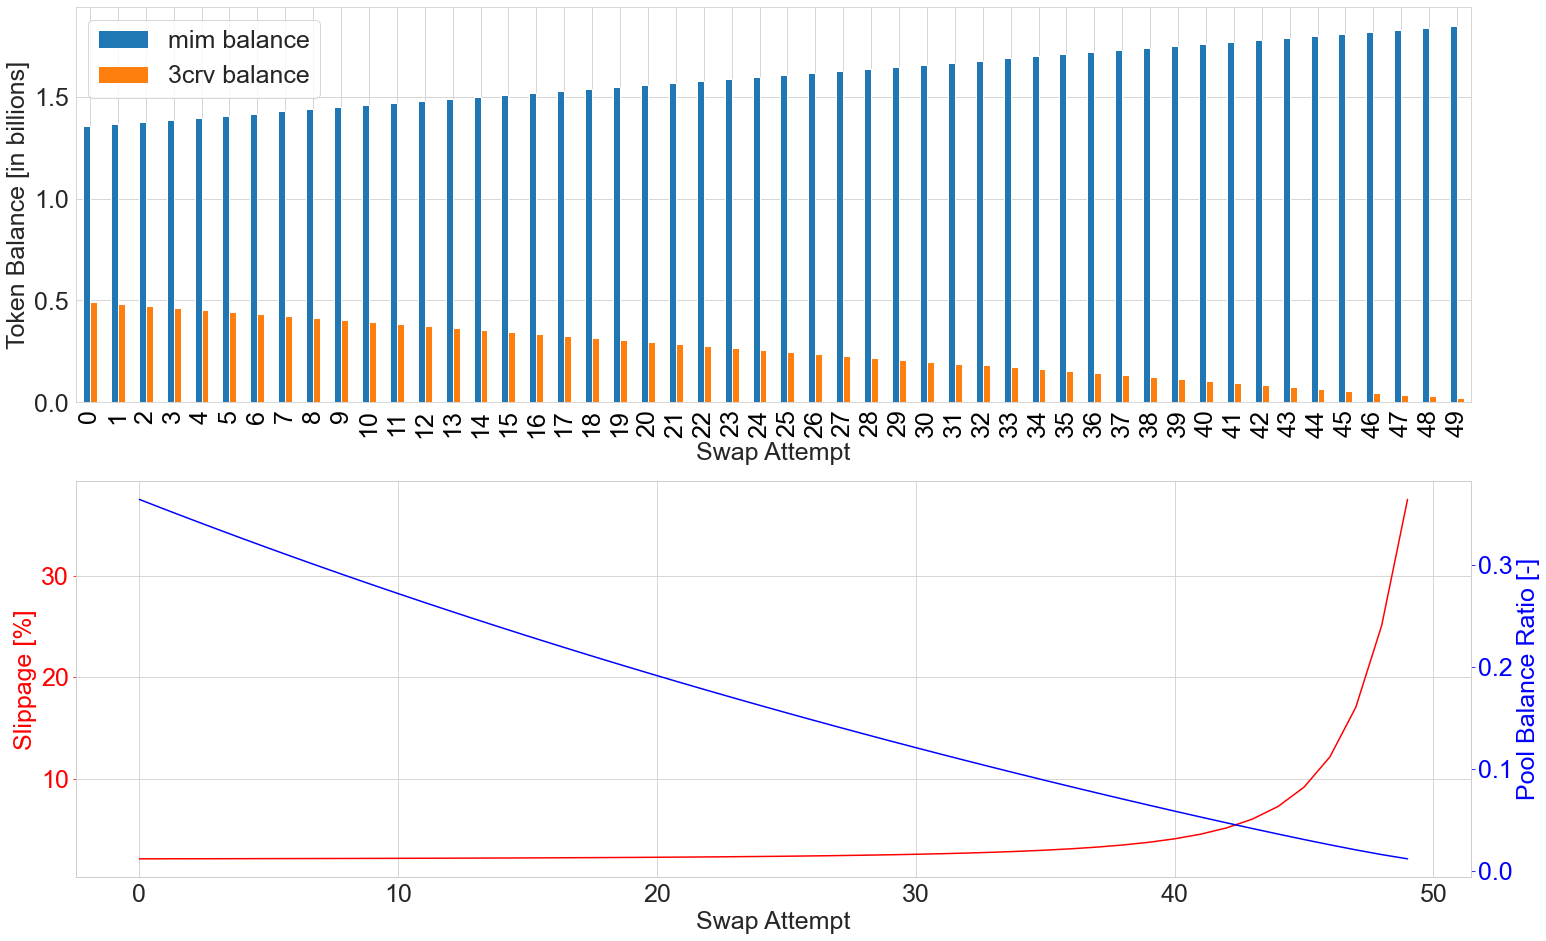

In [24]:
fig, axes = plt.subplots(2,1, figsize=(25, 16))

ax = axes[0]
(df_swap_data[['pool_balance_token_0', 'pool_balance_token_1']] * 1e-9).plot(
    ax=ax,
    kind='bar',
    stacked=False
)

ax.set_xlabel("Swap Attempt", fontsize=25)
ax.set_ylabel("Token Balance [in billions]", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(['mim balance', '3crv balance'], fontsize=25, loc=0)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

ax = axes[1]
ax.plot(
    df_swap_data.index,
    abs(df_swap_data.slippage),
    color='red',
    label='abs slippage'
)
ax.set_xlabel("Swap Attempt", fontsize=25)
ax.set_ylabel("Slippage [%]", fontsize=25, color='red')
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', colors='red')

ax2 = ax.twinx()
ax2.plot(
    df_swap_data.index,
    df_swap_data.pool_balance_token_1/df_swap_data.pool_balance_token_0,
    color='blue',
    label='tokens balance ratio (3crv / mim)'
)
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylabel("Pool Balance Ratio [-]", fontsize=25, color='blue')
ax2.tick_params(axis='y', which='major', colors='blue', labelsize=25)
ax2.grid(False);

